In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
import pandas as pd

# Load datasets
orders = pd.read_csv(r"D:\Data Analysis\Pioneers\Final Project\Data\cleaned_data\olist_orders_dataset.csv")
order_items = pd.read_csv(r"D:\Data Analysis\Pioneers\Final Project\Data\cleaned_data\olist_order_items_dataset.csv")
order_reviews = pd.read_csv(r"D:\Data Analysis\Pioneers\Final Project\Data\cleaned_data\olist_order_reviews_dataset_df.csv")
products = pd.read_csv(r"D:\Data Analysis\Pioneers\Final Project\Data\cleaned_data\olist_products_dataset.csv")
payments = pd.read_csv(r"D:\Data Analysis\Pioneers\Final Project\Data\cleaned_data\olist_order_payments_dataset.csv")
customers = pd.read_csv(r"D:\Data Analysis\Pioneers\Final Project\Data\cleaned_data\olist_customers_dataset.csv")

,order_id,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,-8.0,8.72,38.71,"credit_card, voucher",29.99,utilidades_domesticas,1.0,SP,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,-36.0,22.76,141.46,boleto,118.70,perfumaria,1.0,BA,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,130.0,19.22,179.12,credit_card,159.90,automotivo,1.0,GO,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,-306.0,27.20,72.20,credit_card,45.00,pet_shop,1.0,RN,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,-10.0,8.72,28.62,credit_card,19.90,papelaria,1.0,SP,5.0


In [10]:
# Most frequent payment_type
payments = payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_type': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
}).reset_index()


In [133]:
# Step 1: Merge order_items with products to get product_category_name and price
df = olist_order_items_dataset.merge(
    olist_products_dataset[['product_id', 'product_category_name']], 
    on='product_id',
    how='left'
)

# Step 2: Merge with orders to get delivery_date and estimated_delivery_date
df = df.merge(
    olist_orders_dataset[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_id']],
    on='order_id',
    how='left'
)

# Step 3: Add customer info (customer_state)
df = df.merge(
    olist_customers_dataset[['customer_id', 'customer_state']],
    on='customer_id',
    how='left'
)

# Step 4: Add payment info from payments dataset (payment_value, payment_type)
payment_summary = olist_order_payments_dataset.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_type': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
}).reset_index()

df = df.merge(payment_summary, on='order_id', how='left')

# Step 5: Calculate delivery_delay
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days

# Step 6: Add order_item_count per order
item_count = olist_order_items_dataset.groupby('order_id')['order_item_id'].count().reset_index()
item_count.rename(columns={'order_item_id': 'order_item_count'}, inplace=True)

df = df.merge(item_count, on='order_id', how='left')

# Step 7: Merge review_score
df = df.merge(
    olist_order_reviews_dataset[['order_id', 'review_score']],
    on='order_id',
    how='left'
)

# Final DataFrame with required columns
final_df = df[['delivery_delay', 'freight_value', 'payment_value', 'payment_type', 'price',
               'product_category_name', 'order_item_count', 'customer_state', 'review_score']]

# Display the final DataFrame
final_df.head()


,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
0,-9.0,13.29,72.19,credit_card,58.90,cool_stuff,1,RJ,5.0
1,204.0,19.93,259.83,credit_card,239.90,pet_shop,1,SP,4.0
2,-100.0,17.87,216.87,credit_card,199.00,moveis_decoracao,1,MG,5.0
3,-6.0,12.79,25.78,credit_card,12.99,perfumaria,1,SP,4.0
4,-73.0,18.14,218.04,credit_card,199.90,ferramentas_jardim,1,SP,5.0


In [134]:
final_df.shape

(113314, 9)

In [136]:
print(final_df.isnull().sum())

delivery_delay           2475
freight_value               0
payment_value               3
payment_type                3
price                       0
product_category_name    1612
order_item_count            0
customer_state              0
review_score              942
dtype: int64


In [138]:
final_df['product_category_name'] = final_df['product_category_name'].fillna('unknown')

<ipython-input-138-8b521c880a38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['product_category_name'] = final_df['product_category_name'].fillna('unknown')


In [141]:
print(final_df.isnull().sum())

delivery_delay           2475
freight_value               0
payment_value               3
payment_type                3
price                       0
product_category_name       0
order_item_count            0
customer_state              0
review_score              942
dtype: int64


In [142]:
final_df = final_df.dropna()
print(final_df.isnull().sum())

delivery_delay           0
freight_value            0
payment_value            0
payment_type             0
price                    0
product_category_name    0
order_item_count         0
customer_state           0
review_score             0
dtype: int64


In [143]:
final_df['review_score'] = final_df['review_score'].astype(int)

In [144]:
final_df.head()

,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
0,-9.0,13.29,72.19,credit_card,58.90,cool_stuff,1,RJ,5
1,204.0,19.93,259.83,credit_card,239.90,pet_shop,1,SP,4
2,-100.0,17.87,216.87,credit_card,199.00,moveis_decoracao,1,MG,5
3,-6.0,12.79,25.78,credit_card,12.99,perfumaria,1,SP,4
4,-73.0,18.14,218.04,credit_card,199.90,ferramentas_jardim,1,SP,5


In [145]:
# Convert review_score to categorical
final_df['review_score'] = final_df['review_score'].astype('category')

In [146]:
final_df.head()

,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
0,-9.0,13.29,72.19,credit_card,58.90,cool_stuff,1,RJ,5
1,204.0,19.93,259.83,credit_card,239.90,pet_shop,1,SP,4
2,-100.0,17.87,216.87,credit_card,199.00,moveis_decoracao,1,MG,5
3,-6.0,12.79,25.78,credit_card,12.99,perfumaria,1,SP,4
4,-73.0,18.14,218.04,credit_card,199.90,ferramentas_jardim,1,SP,5


In [147]:
# Find and Count all duplicate rows
duplicates = final_df[final_df.duplicated()]
duplicates

,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
14,-97.0,13.37,126.54,boleto,49.90,ferramentas_jardim,2,SP,5
43,-12.0,17.63,127.56,boleto,24.89,eletronicos,3,BA,4
44,-12.0,17.63,127.56,boleto,24.89,eletronicos,3,BA,4
49,2.0,7.78,53.54,credit_card,18.99,beleza_saude,2,SP,1
76,-7.0,8.90,173.80,credit_card,78.00,utilidades_domesticas,2,SP,4
...,...,...,...,...,...,...,...,...,...
113281,7.0,15.79,113.07,credit_card,21.90,eletronicos,3,BA,2
113299,76.0,48.14,456.28,credit_card,180.00,informatica_acessorios,2,PB,5
113305,-10.0,34.19,356.76,boleto,55.00,relogios_presentes,4,PE,4
113306,-10.0,34.19,356.76,boleto,55.00,relogios_presentes,4,PE,4


In [148]:
final_df.shape

(110009, 9)

In [149]:
Data = final_df.drop_duplicates()

In [150]:
Data.shape

(98401, 9)

In [151]:
# Label encode payment_type and product_category_name
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

Data['payment_type'] = label_encoder.fit_transform(Data['payment_type'])
Data['product_category_name'] = label_encoder.fit_transform(Data['product_category_name'])


<ipython-input-151-9a73a55c8410>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['payment_type'] = label_encoder.fit_transform(Data['payment_type'])
<ipython-input-151-9a73a55c8410>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['product_category_name'] = label_encoder.fit_transform(Data['product_category_name'])


In [152]:
Data['customer_state'] = label_encoder.fit_transform(Data['customer_state'])

<ipython-input-152-dc6cba4b16dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['customer_state'] = label_encoder.fit_transform(Data['customer_state'])


In [153]:
Data.head()

,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
0,-9.0,13.29,72.19,1,58.90,26,1,18,5
1,204.0,19.93,259.83,1,239.90,63,1,25,4
2,-100.0,17.87,216.87,1,199.00,54,1,10,5
3,-6.0,12.79,25.78,1,12.99,62,1,25,4
4,-73.0,18.14,218.04,1,199.90,40,1,25,5


In [154]:
from sklearn.preprocessing import StandardScaler

# Columns you want to scale
cols_to_scale = ['freight_value', 'payment_value', 'price', 'order_item_count', 'delivery_delay']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
Data[cols_to_scale] = scaler.fit_transform(Data[cols_to_scale])


<ipython-input-154-bc70f2f93592>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data[cols_to_scale] = scaler.fit_transform(Data[cols_to_scale])
C:\Users\Youss\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [155]:
# 1. Convert review_score to integers starting from 0
# This ensures the labels are in range [0, 1, 2, 3, 4] for classification
Data['review_score'] = Data['review_score'].astype(int) - 1


<ipython-input-155-ad7377fc498f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['review_score'] = Data['review_score'].astype(int) - 1


In [156]:
# Features (X) and Target (y)
x = Data.drop(['review_score'], axis=1)  # All columns except 'review_score'
y = Data['review_score']  # Target variable


In [157]:
y.shape

(98401,)

In [158]:
X.head()

,delivery_delay,payment_value,payment_type,price,product_category_name,order_item_count,customer_state
0,0.024306,-0.565861,3,-0.503698,73,-0.297963,25
1,-0.217598,-0.098925,0,-0.029309,62,-0.297963,4
2,1.216548,0.072217,1,0.191014,8,-0.297963,8
3,-2.550246,-0.413670,1,-0.423430,63,-0.297963,19
4,0.007027,-0.611714,1,-0.557655,59,-0.297963,25


In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [160]:
from xgboost import XGBClassifier

In [161]:
y_train

77360    4
77105    3
58767    3
94643    0
93919    4
        ..
7152     4
63175    4
88435    3
982      4
18110    4
Name: review_score, Length: 78720, dtype: int32

In [162]:
# Train model
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [165]:
from sklearn.metrics import classification_report

In [166]:
# Step 4: Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.14      0.22      2104
           1       0.33      0.00      0.01       644
           2       0.12      0.00      0.00      1645
           3       0.32      0.01      0.02      3921
           4       0.59      0.98      0.74     11367

    accuracy                           0.58     19681
   macro avg       0.37      0.23      0.20     19681
weighted avg       0.48      0.58      0.45     19681



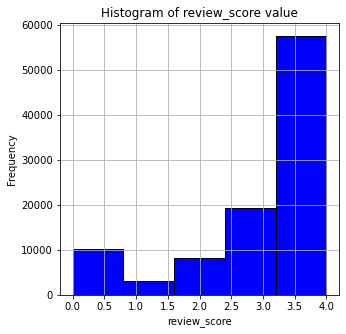

In [167]:
# Create a histogram
y.hist(bins=5, figsize=(5, 5), color='blue', edgecolor='black')

# Labels and Title
plt.xlabel('review_score')
plt.ylabel('Frequency')
plt.title('Histogram of review_score value')

# Show the plot
plt.show()

In [168]:
Data.head()

,delivery_delay,freight_value,payment_value,payment_type,price,product_category_name,order_item_count,customer_state,review_score
0,0.015666,-0.432545,-0.413715,1,-0.349098,26,-0.297963,18,4
1,1.855866,-0.012154,0.438995,1,0.618825,63,-0.297963,25,3
2,-0.770522,-0.142576,0.243768,1,0.400106,54,-0.297963,10,4
3,0.041585,-0.464201,-0.624620,1,-0.594608,62,-0.297963,25,3
4,-0.537258,-0.125482,0.249085,1,0.404919,40,-0.297963,25,4


# new model

In [124]:
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
merged['shipping_time'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days


In [170]:
# Convert necessary date columns to datetime
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
merged['shipping_limit_date'] = pd.to_datetime(merged['shipping_limit_date'])

# Shipping time
merged['shipping_time'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days

# Days to ship
merged['days_to_ship'] = (merged['shipping_limit_date'] - merged['order_purchase_timestamp']).dt.days

# Customer purchase frequency
customer_order_freq = orders.groupby('customer_id')['order_id'].count().reset_index(name='customer_purchase_frequency')
merged = merged.merge(customer_order_freq, on='customer_id', how='left')

# Average product price per category
price_by_category = order_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
avg_price_per_category = price_by_category.groupby('product_category_name')['price'].mean().reset_index(name='avg_price_per_category')
merged = merged.merge(avg_price_per_category, on='product_category_name', how='left')


In [127]:
merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_state,price,freight_value,product_id,order_item_id,product_category_name,payment_value,payment_type,review_score,delivery_delay,order_item_count,shipping_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-02-10 10:56:00,02/10/2017 11:07,04/10/2017 19:55,2017-10-10 21:25:00,2017-10-18,SP,29.99,8.72,87285b34884572647811a353c7ac498a,1.0,utilidades_domesticas,38.71,voucher,4.0,-8.0,1.0,242.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,26/07/2018 03:24,26/07/2018 14:31,2018-07-08 15:27:00,2018-08-13,BA,118.70,22.76,595fac2a385ac33a80bd5114aec74eb8,1.0,perfumaria,141.46,boleto,4.0,-36.0,1.0,-17.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,08/08/2018 08:55,08/08/2018 13:50,2018-08-17 18:06:00,2018-04-09,GO,159.90,19.22,aa4383b373c6aca5d8797843e5594415,1.0,automotivo,179.12,credit_card,5.0,130.0,1.0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,18/11/2017 19:45,22/11/2017 13:39,2017-02-12 00:28:00,2017-12-15,RN,45.00,27.20,d0b61bfb1de832b15ba9d266ca96e5b0,1.0,pet_shop,72.20,credit_card,5.0,-306.0,1.0,-280.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,13/02/2018 22:20,14/02/2018 19:46,2018-02-16 18:17:00,2018-02-26,SP,19.90,8.72,65266b2da20d04dbe00c5c2d3bb7859e,1.0,papelaria,28.62,credit_card,5.0,-10.0,1.0,2.0


In [130]:
# Convert necessary date columns to datetime
merged['order_purchase_timestamp'] = pd.to_datetime(merged['order_purchase_timestamp'])
merged['shipping_limit_date'] = pd.to_datetime(merged['shipping_limit_date'])

# Shipping time
merged['shipping_time'] = (merged['order_delivered_customer_date'] - merged['order_purchase_timestamp']).dt.days

# Days to ship
merged['days_to_ship'] = (merged['shipping_limit_date'] - merged['order_purchase_timestamp']).dt.days

# Customer purchase frequency
customer_order_freq = orders.groupby('customer_id')['order_id'].count().reset_index(name='customer_purchase_frequency')
merged = merged.merge(customer_order_freq, on='customer_id', how='left')

# Average product price per category
price_by_category = order_items.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
avg_price_per_category = price_by_category.groupby('product_category_name')['price'].mean().reset_index(name='avg_price_per_category')
merged = merged.merge(avg_price_per_category, on='product_category_name', how='left')


In [119]:
# Define target and features
X = Data.drop(columns=['freight_value', 'review_score'])
y = Data['freight_value']



In [120]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [121]:
# Use Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [122]:
# Predictions and evaluation
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

MAE: 0.08978181153602915
RMSE: 0.36177278963249
R2: 0.8624876667833861
